# Self Driving Car Engineer Project 4 - Advanced Lane Line Detection
**Benjamin Söllner**

<br />
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Useful Packages, Configuration, and Helper Functions

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
TEST_IMAGES = glob.glob('test_images/*.jpg')
TEST_COLS = 3
CAL_PICKLE_FILE = "pickles/cal.p" 
CAL_TEST_IMAGE = "camera_cal/calibration1.jpg"
THRESH_TEST_IMAGE = "test_images/test6.jpg"
THRESH_MAG = (10, 130)
THRESH_DIR = (0.7, 1.5)
THRESH_S = (15, 255)
UNWARP_PLANE = [(604,440), (671,440), (1064,660), (226,660)]
UNWARP_X_OFFSET = 280
UNWARP_Y_OFFSET = 20
UNWARP_TEST_IMAGE = "test_images/straight_lines1.jpg"
LANE_Y_M_PER_PIX = 30/720
LANE_X_M_PER_PIX = 3.7/700
SEARCH_R_DEV_THRESHOLD = 0.1

# Function to run all test images through function and display them
def run_all_test_images(processing_function, output='image', cmap=None):
    global TEST_IMAGES
    figure, plots = plt.subplots(int(np.ceil(len(TEST_IMAGES)/TEST_COLS)), 3, figsize=(20,10))
    for i, image_name in enumerate(TEST_IMAGES):
        image = cv2.imread(image_name)
        o = processing_function(image)
        p = plots[int(i/TEST_COLS)][i%TEST_COLS]
        if output == 'image':
            if cmap is None:
                p.imshow(o)
            else:
                p.imshow(o, cmap=cmap)
        elif output == 'multiscatter':
            for xys in o:
                p.scatter(xys[0], xys[1])
        p.set_title(ntpath.basename(image_name), fontsize=30)


## Calibrating Camera

**Task:** Compute the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

OpenCV functions or other methods were used to calculate the correct camera matrix and distortion coefficients using the calibration chessboard images provided in the repository. The distortion matrix should be used to un-distort one of the calibration images provided as a demonstration that the calibration is correct. Example of undistorted calibration image is Included in the writeup (or saved to a folder).

### Finding Chessboard Corners

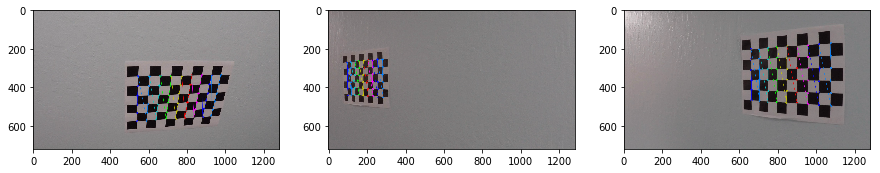

In [3]:
import glob
import ntpath
import itertools
%matplotlib inline

# number of rows and cols on the checkerboard
cal_rows = 6
cal_cols = 9

# prepare object points (3-dimensional), like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
cal_refpoints = np.zeros((cal_rows*cal_cols,3), np.float32)
cal_refpoints[:,:2] = np.mgrid[0:cal_rows, 0:cal_cols].T.reshape(-1,2)

# all object and image points
cal_objpoints = [] # 3d points in real world space
cal_imgpoints = [] # 2d points in image plane.

# list of calibration images
cal_images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
cal_no_checkboard_images = 3
cal_checkboard_images = []
for index, file in enumerate(cal_images):
    image = cv2.imread(file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    returncode, corners = cv2.findChessboardCorners(gray, (cal_rows,cal_cols), None)
    # If found, add object and found image points
    if returncode == True:
        cal_objpoints.append(cal_refpoints)
        cal_imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(image, (cal_rows, cal_cols), corners, returncode)
        output_name = 'debug_images/corners_found_'+ntpath.basename(file)
        cv2.imwrite(output_name, image)
        if len(cal_checkboard_images) < cal_no_checkboard_images:
            cal_checkboard_images.append(image)
        
# Visualize undistortion
figure, plots = plt.subplots(1, cal_no_checkboard_images, figsize=(15,10))
for plot, image in itertools.zip_longest(plots, cal_checkboard_images, fillvalue=None):
    if image is not None:
        plot.imshow(image)


### Calculating & Storing Distortion Parameters

In [4]:
import pickle
%matplotlib inline

# Test undistortion on an image
cal_test_image = cv2.imread('camera_cal/calibration1.jpg')
cal_test_image_size = (cal_test_image.shape[1], cal_test_image.shape[0])

# Do camera calibration given object points and image points
cal_ret, cal_matrix, cal_dist, cal_rvecs, cal_tvecs = \
    cv2.calibrateCamera(cal_objpoints, cal_imgpoints, cal_test_image_size, None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
CAL_PICKLE = {"matrix": cal_matrix, "dist": cal_dist}
pickle.dump( CAL_PICKLE, open( CAL_PICKLE_FILE, "wb" ) )

### Undistortion

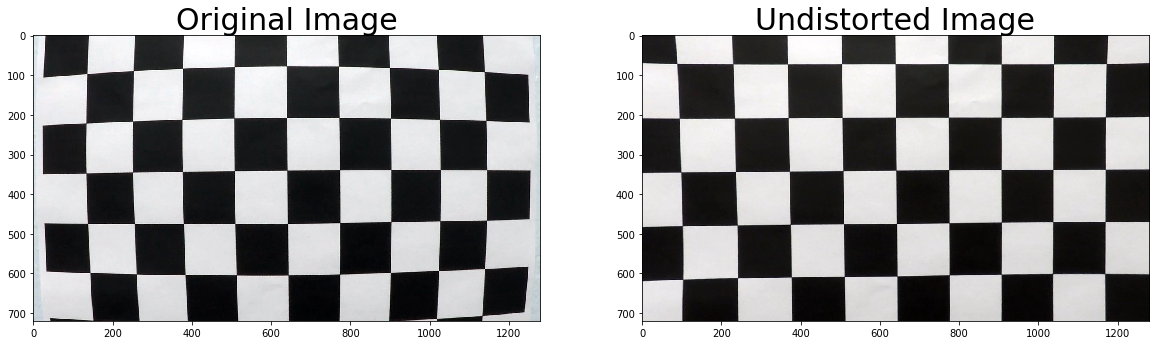

In [5]:
import pickle
%matplotlib inline

CAL_PICKLE = pickle.load(open( CAL_PICKLE_FILE, "rb" ))

def undistort(image):
    global CAL_PICKLE
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return cv2.undistort(image, CAL_PICKLE["matrix"], CAL_PICKLE["dist"], None, CAL_PICKLE["matrix"])

# Test and visualize undistortion
cal_test_image = cv2.imread(CAL_TEST_IMAGE)
cal_test_undistort = undistort(cal_test_image)
cv2.imwrite('debug_images/test_undistort.jpg',cal_test_undistort)

# Visualize undistortion
figure, (plot1, plot2) = plt.subplots(1, 2, figsize=(20,10))
plot1.imshow(cal_test_image)
plot1.set_title('Original Image', fontsize=30)
plot2.imshow(cal_test_undistort)
plot2.set_title('Undistorted Image', fontsize=30)

## Distortion Correction

**Task:** Provide an example of a distortion-corrected image.

Distortion correction that was calculated via camera calibration has been correctly applied to each image. An example of a distortion corrected image should be included in the writeup (or saved to a folder) and submitted with the project.



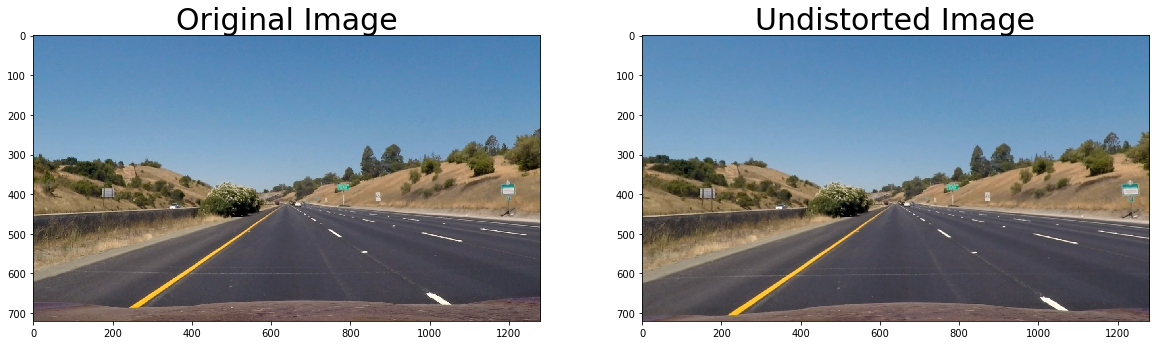

In [6]:
figure, plots = plt.subplots(1, 2, figsize=(20,10))
unwarp_test_image = cv2.imread(UNWARP_TEST_IMAGE)
plots[0].imshow(cv2.cvtColor(unwarp_test_image, cv2.COLOR_BGR2RGB))
plots[0].set_title('Original Image', fontsize=30)
plots[1].imshow(undistort(unwarp_test_image))
plots[1].set_title('Undistorted Image', fontsize=30)


## Unwarping / Perspective Transform

**Task:** Perform a perspective transform and provide an example of a transformed image.

OpenCV function or other method has been used to correctly rectify each image to a "birds-eye view". Transformed images should be included in the writeup (or saved to a folder) and submitted with the project

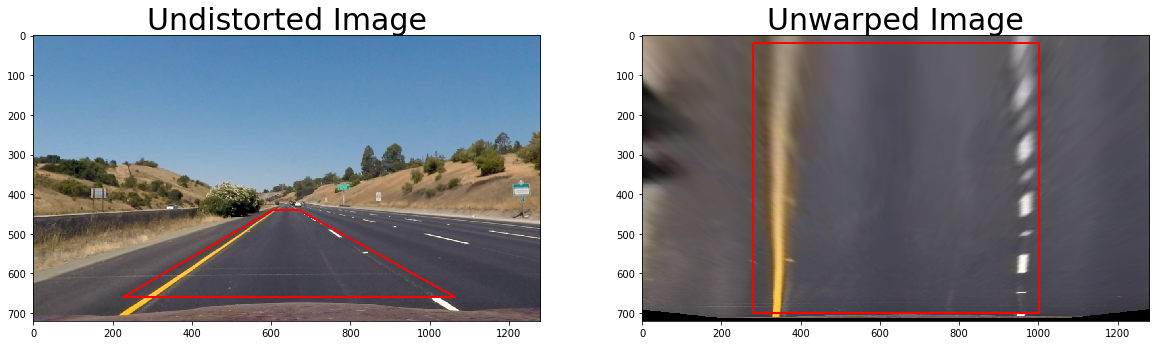

In [7]:
def show_lane_plane(image):
    global UNWARP_PLANE
    undistorted = undistort(image)
    color = [255,0,0]
    for (start, end) in zip([0,1,2,3], [1,2,3,0]):
        cv2.line(undistorted, UNWARP_PLANE[start], UNWARP_PLANE[end], [255,0,0], 3)
    return undistorted
    
def unwarp(image, show_plane=False):
    global UNWARP_PLANE
    global UNWARP_X_OFFSET
    global UNWARP_Y_OFFSET
    undistorted = undistort(image)
    source = UNWARP_PLANE
    x_offset = UNWARP_X_OFFSET 
    y_offset = UNWARP_Y_OFFSET 
    dim = (gray.shape[1], gray.shape[0])
    dest = [(x_offset, y_offset), (dim[0]-x_offset, y_offset), 
            (dim[0]-x_offset, dim[1]-y_offset), (x_offset, dim[1]-y_offset)]
    transform_matrix = cv2.getPerspectiveTransform(np.float32(source), np.float32(dest))
    inverse_matrix = cv2.getPerspectiveTransform(np.float32(dest), np.float32(source))
    unwarped = cv2.warpPerspective(undistorted, transform_matrix, dim, flags=cv2.INTER_LINEAR)
    if show_plane:
        for (start, end) in zip([0,1,2,3], [1,2,3,0]):
            cv2.line(unwarped, dest[start], dest[end], [255,0,0], 3)
    return unwarped, inverse_matrix

# Test and Visualize Unwarping
figure, plots = plt.subplots(1, 2, figsize=(20,10))
unwarp_test_image = cv2.imread(UNWARP_TEST_IMAGE)
unwarped_image, UNWARP_INV_MATRIX = unwarp(unwarp_test_image, show_plane=True)
plots[0].imshow(show_lane_plane(unwarp_test_image))
plots[0].set_title('Undistorted Image', fontsize=30)
plots[1].imshow(unwarped_image)
plots[1].set_title('Unwarped Image', fontsize=30)


## Identifying Lane Line Pixels

**Task:** Use color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

A method or combination of methods (i.e., color transforms, gradients) has been used to create a binary image containing likely lane pixels. There is no "ground truth" here, just visual verification that the pixels identified as part of the lane lines are, in fact, part of the lines. Example binary images should be included in the writeup (or saved to a folder) and submitted with the project.



### Color & Gradient Threshold

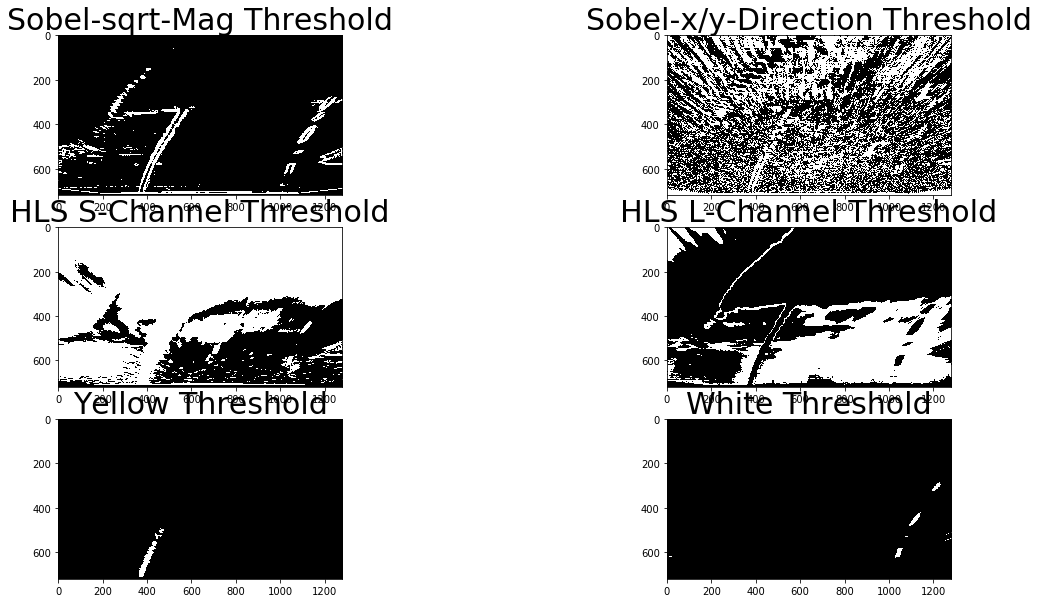

In [8]:
# applies Sobel x and y, then computes the magnitude of the gradient and applies a threshold
def mag_threshold(image, sobel_kernel=5, mag_thresh=(0, 255)):
    unwarped = unwarp(image)[0]
    # Convert to grayscale
    gray = cv2.cvtColor(unwarped, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude 
    grad_mag = np.sqrt(sobel_x**2 + sobel_y**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(grad_mag)/255 
    grad_mag = (grad_mag/scale_factor).astype(np.uint8) 
    # Create a binary mask where mag thresholds are met
    mask = np.zeros_like(grad_mag)
    mask[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1
    # Return this mask as your binary_output image
    return mask

# applies Sobel x and y, then computes the direction of the gradient and applies a threshold.
def dir_threshold(image, sobel_kernel=5, thresh=(0, np.pi/2)):
    unwarped = unwarp(image)[0]
    # Convert to grayscale
    gray = cv2.cvtColor(unwarped, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    # Create a binary mask where direction thresholds are met
    mask =  np.zeros_like(direction)
    mask[(direction < thresh[0]) | (direction > thresh[1])] = 1
    # Return this mask as your binary_output image
    return mask

# thresholds the S-channel of HLS; use exclusive lower bound (>) and inclusive upper (<=)
def s_threshold(img, thresh=(0, 255)):
    unwarped = unwarp(img)[0]
    # Convert to HLS color space
    hls = cv2.cvtColor(unwarped, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    s = hls[:,:,2]
    mask = np.zeros_like(s)
    mask[(s >= thresh[0]) & (s <= thresh[1])] = 1
    # Return a binary image of threshold result
    return mask

def l_threshold(img, thresh=(0, 255)):
    unwarped = unwarp(img)[0]
    # Convert to HLS color space
    hls = cv2.cvtColor(unwarped, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    l = hls[:,:,1]
    mask = np.zeros_like(l)
    mask[(l >= thresh[0]) & (l <= thresh[1])] = 1
    # Return a binary image of threshold result
    return mask

def yellow_threshold(image):
    unwarped = unwarp(image)[0]
    hsv = cv2.cvtColor(unwarped, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(hsv, (20, 100, 100), (50, 255, 255))
    yellow_mask = np.float_(np.zeros_like(yellow))
    yellow_mask[yellow>0] = 1.0
    return yellow_mask

def white_threshold(image):
    unwarped = unwarp(image)[0]
    hsv = cv2.cvtColor(unwarped, cv2.COLOR_RGB2HSV)
    hsl = cv2.cvtColor(unwarped, cv2.COLOR_RGB2HLS)
    white_sensitivity_1 = 68
    white_sensitivity_2 = 60
    white_1 = cv2.inRange(hsv, (0,0,255-white_sensitivity_1), (255,20,255))
    white_2 = cv2.inRange(hsl, (0,255-white_sensitivity_2,0), (255,255,white_sensitivity_2))
    white_3 = cv2.inRange(unwarped, (200,200,200), (255,255,255))
    white = white_1|white_2|white_3
    white_mask = np.float_(np.zeros_like(white))
    white_mask[white>0] = 1.0
    return white_mask

# Test and Visualize Different thresholds
thresh_test_image = cv2.imread(THRESH_TEST_IMAGE)
figure, plots = plt.subplots(3, 2, figsize=(20,10))
plots[0,0].imshow(mag_threshold(thresh_test_image, mag_thresh=THRESH_MAG), cmap='gray')
plots[0,0].set_title('Sobel-sqrt-Mag Threshold', fontsize=30)
plots[0,1].imshow(dir_threshold(thresh_test_image, thresh=THRESH_DIR), cmap='gray')
plots[0,1].set_title('Sobel-x/y-Direction Threshold', fontsize=30)
plots[1,0].imshow(s_threshold(thresh_test_image, thresh=THRESH_S), cmap='gray')
plots[1,0].set_title('HLS S-Channel Threshold', fontsize=30)
plots[1,1].imshow(l_threshold(thresh_test_image, thresh=(70,90)), cmap='gray')
plots[1,1].set_title('HLS L-Channel Threshold', fontsize=30)
plots[2,0].imshow(yellow_threshold(thresh_test_image), cmap='gray')
plots[2,0].set_title('Yellow Threshold', fontsize=30)
plots[2,1].imshow(white_threshold(thresh_test_image), cmap='gray')
plots[2,1].set_title('White Threshold', fontsize=30)


### Combining Filters

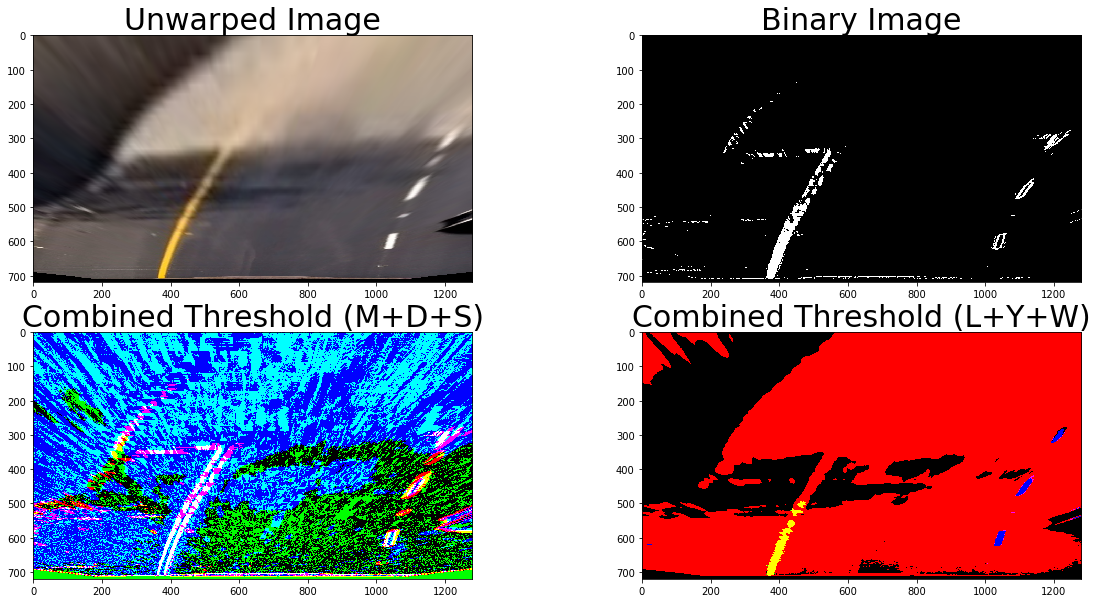

In [9]:
def combined_threshold(image):
    global THRESH_MAG
    global THRESH_DIR
    global THRESH_S
    m = mag_threshold(image, mag_thresh=THRESH_MAG)
    d = dir_threshold(image, thresh=THRESH_DIR)
    s = s_threshold(image, thresh=THRESH_S)
    l = l_threshold(image, thresh=(70,200))
    y = yellow_threshold(image)
    w = white_threshold(image)
    color_binary = np.dstack((m, d, s, l, y, w))
    return color_binary

def find_lane_line_pixels(image):
    combined = combined_threshold(image)
    m = combined[:,:,0].astype(int)
    d = combined[:,:,1].astype(int)
    s = combined[:,:,2].astype(int)
    l = combined[:,:,3].astype(int)
    y = combined[:,:,4].astype(int)
    w = combined[:,:,5].astype(int)
    # Require that at least two filters or one of the color filters score
    binary = ((y*2+w*2+l+(m&s)+(m&d))>=3)
    return binary.astype(float)


# Test and Visualize Combined thresholds
thresh_test_image = cv2.imread(THRESH_TEST_IMAGE)
figure, plots = plt.subplots(2, 2, figsize=(20,10))
plots[0,0].imshow(unwarp(thresh_test_image)[0])
plots[0,0].set_title('Unwarped Image', fontsize=30)
plots[0,1].imshow(find_lane_line_pixels(thresh_test_image), cmap='gray')
plots[0,1].set_title('Binary Image', fontsize=30)
plots[1,0].imshow(combined_threshold(thresh_test_image)[:,:,0:3])
plots[1,0].set_title('Combined Threshold (M+D+S)', fontsize=30)
plots[1,1].imshow(combined_threshold(thresh_test_image)[:,:,3:6])
plots[1,1].set_title('Combined Threshold (L+Y+W)', fontsize=30)

## Finding Lane Lines & Fitting Polynomial

**Task:** Identify lane-line pixels and fit their positions with a polynomial?

Methods have been used to identify lane line pixels in the rectified binary image. The left and right line have been identified and fit with a curved functional form (e.g., spine or polynomial). Example images with line pixels identified and a fit overplotted should be included in the writeup (or saved to a folder) and submitted with the project.

### Finding Lane Line Base

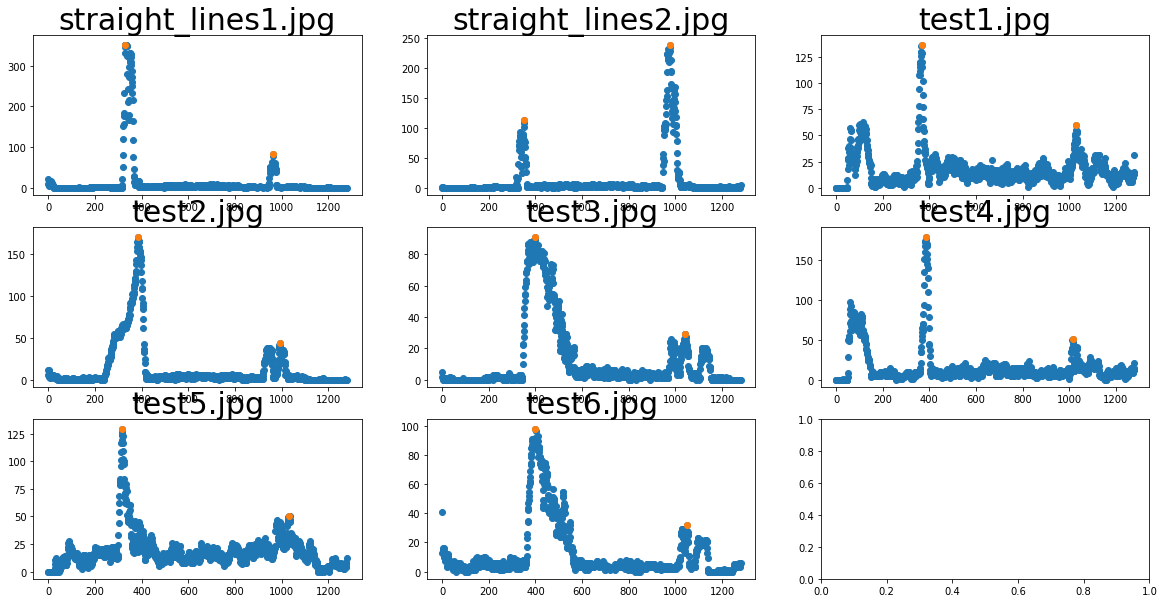

In [10]:
def halfhist(image):
    return np.sum(image[image.shape[0]//2:,:], axis=0)

def find_peaks(histogram):
    centerx = np.int(histogram.shape[0]/2)
    leftx_max = np.argmax(histogram[:centerx])
    rightx_max = np.argmax(histogram[centerx:]) + centerx
    return leftx_max, rightx_max

def find_base(lane_line_pixels):
    histogram = halfhist(lane_line_pixels)
    leftx_max, rightx_max = find_peaks(histogram)
    histogram_xs_ys = (range(0, len(histogram)), histogram)
    max_xs_ys = ([leftx_max, rightx_max], [histogram[leftx_max], histogram[rightx_max]])
    return [histogram_xs_ys, max_xs_ys]

def find_base_test(image):
    lane_line_pixels = find_lane_line_pixels(image)
    return find_base(lane_line_pixels)

run_all_test_images(find_base_test, output='multiscatter')


### Lane Line Class

In [11]:
import collections

class LaneLine:
    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys
        self.fit = None
        self.err = None
        self.fit_poly()
    
    def fit_poly(self):
        # Fit a second order polynomial to each
        poly = np.polyfit(self.ys, self.xs, 2, full=True)
        self.fit, self.err = poly[0], poly[1]
        
    def sample_poly(self, ys, yoffset=0):
        return self.fit[0]*ys**2 + self.fit[1]*ys + self.fit[2] + yoffset
            
    def curvature(self, y):
        global LANE_Y_M_PER_PIX
        global LANE_X_M_PER_PIX
        fit = np.polyfit(self.ys*LANE_Y_M_PER_PIX, self.xs*LANE_X_M_PER_PIX, 2)
        return ((1 + (2*fit[0]*y*LANE_Y_M_PER_PIX + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    
    def __add__(self, other):
        self_dict = dict(zip(self.xs, self.ys))
        ys = []
        for other_x, other_y in zip(other.xs, other.ys):
            if other_x in self_dict:
                self_y = self_dict[other_x]
                ys.append(int(other_y + self_y))
            else:
                ys.append(other_y)
        return LaneLine(other.xs, np.array(ys))
    
    def __truediv__(self, other):
        return LaneLine(self.xs, np.array([int(y/other) for y in self.ys]))
    
    def __mul__(self, other):
        return LaneLine(self.xs, np.array([int(y*other) for y in self.ys]))

In [12]:
class Lane:
    def __init__(self, left_line, right_line):
        self.left = left_line
        self.right = right_line
    
    def curvature(self, y):
        l = self.left.curvature(y)
        r = self.right.curvature(y)
        return (l+r)/2
    
    def insanity(self, ys):
        ds = []
        for y in ys:
            l = self.left.fit[0]*ys**2 + self.left.fit[1]*ys + self.left.fit[2]
            r = self.right.fit[0]*ys**2 + self.right.fit[1]*ys + self.right.fit[2]
            ds.append(r-l)
        return np.std(ds)
    
    def offset_from_center(self, y, x_vehicle_center):
        global LANE_X_M_PER_PIX
        x_l = self.left.sample_poly(y)
        x_r = self.right.sample_poly(y)
        x_lane_center = (x_r-x_l)/2
        return (x_lane_center-x_vehicle_center)*LANE_X_M_PER_PIX
    
    def __add__(self, other):
        return Lane(self.left+other.left, self.right+other.right)
    
    def __truediv__(self, other):
        return Lane(self.left/other, self.right/other)
    
    def __mul__(self, other):
        return Lane(self.left*other, self.right*other)

### Sliding Window Search

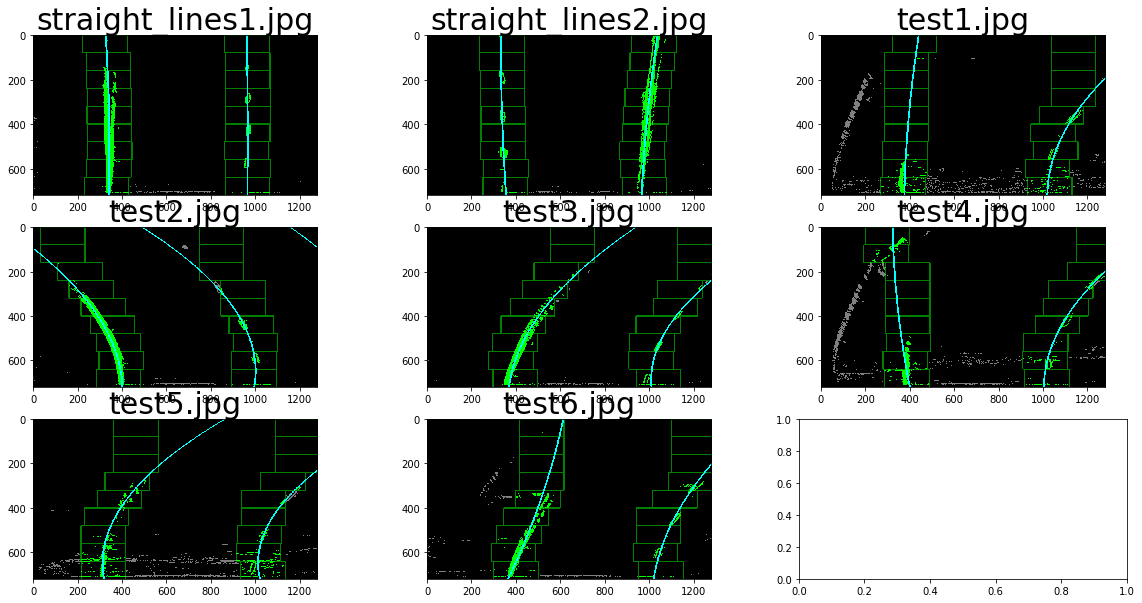

In [13]:
# nwindows = number of sliding windows
# wmargin = Set the width of the windows +/- margin
# minpix = minimum number of pixels found to recenter window
def slidewindow_search(image, nwindows=9, wmargin=100, minpix=50):
    # preprocess image and find base line pixels
    lane_line_img = find_lane_line_pixels(image)
    _, max_xs_ys = find_base(lane_line_img)
    leftx_base  = max_xs_ys[0][0]
    rightx_base = max_xs_ys[0][1]
    wheight = np.int(lane_line_img.shape[0]/nwindows)
    # Output image
    out_img = np.dstack((lane_line_img*.5, lane_line_img*.5, lane_line_img*.5))
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = lane_line_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_now = leftx_base
    rightx_now = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_idxs = []
    right_idxs = []
    # Step through sliding windows
    for w in range(nwindows):
        # Identify sliding windows
        w_y_lo = lane_line_img.shape[0] - (w+1)*wheight
        w_y_hi = lane_line_img.shape[0] - w*wheight
        w_xleft_lo = leftx_now - wmargin
        w_xleft_hi = leftx_now + wmargin
        w_xright_lo = rightx_now - wmargin
        w_xright_hi = rightx_now + wmargin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(w_xleft_lo,w_y_lo),(w_xleft_hi,w_y_hi),(0.,0.5,0.), 4) 
        cv2.rectangle(out_img,(w_xright_lo,w_y_lo),(w_xright_hi,w_y_hi),(0.,0.5,0.), 4) 
        # Identify the nonzero pixels in x and y within the window
        w_left_idxs = ((nonzeroy >= w_y_lo) & (nonzeroy < w_y_hi) & (nonzerox >= w_xleft_lo) & (nonzerox < w_xleft_hi)).nonzero()[0]
        w_right_idxs = ((nonzeroy >= w_y_lo) & (nonzeroy < w_y_hi) & (nonzerox >= w_xright_lo) & (nonzerox < w_xright_hi)).nonzero()[0]
        # Append indices to the lists
        left_idxs.extend(w_left_idxs)
        right_idxs.extend(w_right_idxs)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(w_left_idxs) > minpix:
            leftx_now = np.int(np.mean(nonzerox[w_left_idxs]))
        if len(w_right_idxs) > minpix:        
            rightx_now = np.int(np.mean(nonzerox[w_right_idxs]))
    # Extract left and right line pixel positions
    left_xs = nonzerox[left_idxs]
    left_ys = nonzeroy[left_idxs]
    right_xs = nonzerox[right_idxs]
    right_ys = nonzeroy[right_idxs] 
    # Get Lane Lines
    left_line = LaneLine(left_xs, left_ys)
    right_line = LaneLine(right_xs, right_ys)
    # visualize for debug purposes
    out_img[nonzeroy[left_idxs], nonzerox[left_idxs]] = [0., 1., 0.]
    out_img[nonzeroy[right_idxs], nonzerox[right_idxs]] = [0., 1., 0.]
    fit_ys = np.linspace(0, lane_line_img.shape[0]-1, lane_line_img.shape[0] )
    left_fit_xs = left_line.sample_poly(fit_ys)
    right_fit_xs = right_line.sample_poly(fit_ys)
    for y, left_x, right_x in zip(fit_ys, left_fit_xs, right_fit_xs):
        out_img[int(y), int(left_x-4):int(left_x+4)] = [0., 1., 1.]
        out_img[int(y), int(right_x-4):int(right_x+4)] = [0., 1., 1.]
    return Lane(left_line, right_line), out_img
    
def slidewindow_and_plot(image):
    _, out_img = slidewindow_search(image)
    return out_img
    
run_all_test_images(slidewindow_and_plot)


### Proximity Search

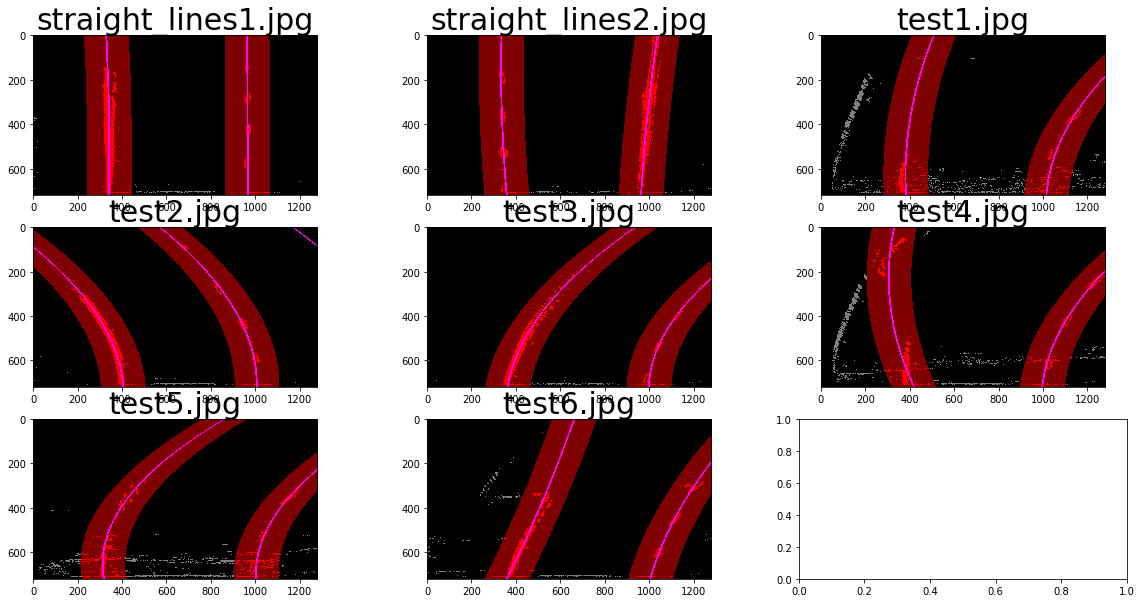

In [14]:
def proximity_search(old_lane, image, pmargin=100):
    lane_line_img = find_lane_line_pixels(image)
    nonzero = lane_line_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_idxs = ((nonzerox > old_lane.left.sample_poly(nonzeroy, yoffset=-pmargin)) & \
                (nonzerox < old_lane.left.sample_poly(nonzeroy, yoffset=+pmargin)))
    right_idxs = ((nonzerox > old_lane.right.sample_poly(nonzeroy, yoffset=-pmargin)) & \
                 (nonzerox < old_lane.right.sample_poly(nonzeroy, yoffset=+pmargin)))
    left_xs = nonzerox[left_idxs]
    left_ys = nonzeroy[left_idxs] 
    right_xs = nonzerox[right_idxs]
    right_ys = nonzeroy[right_idxs]
    # Fit a second order polynomial to each
    # Get Lane Lines
    left_line = LaneLine(left_xs, left_ys)
    right_line = LaneLine(right_xs, right_ys)
    # visualize for debug purposes
    out_img = np.dstack((lane_line_img, lane_line_img, lane_line_img))
    window_img = np.zeros_like(out_img)
    # Generate x and y values for plotting
    fit_ys = np.linspace(0, lane_line_img.shape[0]-1, lane_line_img.shape[0] )
    left_fit_xs = left_line.sample_poly(fit_ys)
    right_fit_xs = right_line.sample_poly(fit_ys)
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_window_1 = np.array([np.transpose(np.vstack([left_fit_xs-pmargin, fit_ys]))])
    left_window_2 = np.array([np.flipud(np.transpose(np.vstack([left_fit_xs+pmargin, fit_ys])))])
    left_line_pts = np.hstack((left_window_1, left_window_2))
    right_window_1 = np.array([np.transpose(np.vstack([right_fit_xs-pmargin, fit_ys]))])
    right_window_2 = np.array([np.flipud(np.transpose(np.vstack([right_fit_xs+pmargin, fit_ys])))])
    right_line_pts = np.hstack((right_window_1, right_window_2))
    # Red: Draw the lane onto the warped blank image
    out_img = np.dstack((lane_line_img*.5, lane_line_img*.5, lane_line_img*.5))
    cv2.fillPoly(out_img, np.int_([left_line_pts]), (0.5, 0., 0.))
    cv2.fillPoly(out_img, np.int_([right_line_pts]), (0.5, 0., 0.))
    # Red: Color in left and right line pixels
    out_img[nonzeroy[right_idxs], nonzerox[right_idxs]] = [1., 0., 0.]
    out_img[nonzeroy[left_idxs], nonzerox[left_idxs]] = [1., 0., 0.]
    # Magenta: Plot polygon
    for y, left_x, right_x in zip(fit_ys, left_fit_xs, right_fit_xs):
        out_img[int(y), int(left_x-4):int(left_x+4)] = [1., 0., 1.]
        out_img[int(y), int(right_x-4):int(right_x+4)] = [1., 0., 1.]
    # Return polynoms + output image
    return Lane(left_line, right_line), out_img

def proximity_and_plot(image):
    # simple slide window search first to get estimate for polygon
    old_lane, _ = slidewindow_search(image)
    # then do proximity search on same image
    _, out_img = proximity_search(old_lane, image)
    return out_img
    
run_all_test_images(proximity_and_plot)


### Combining Both Search Strategies

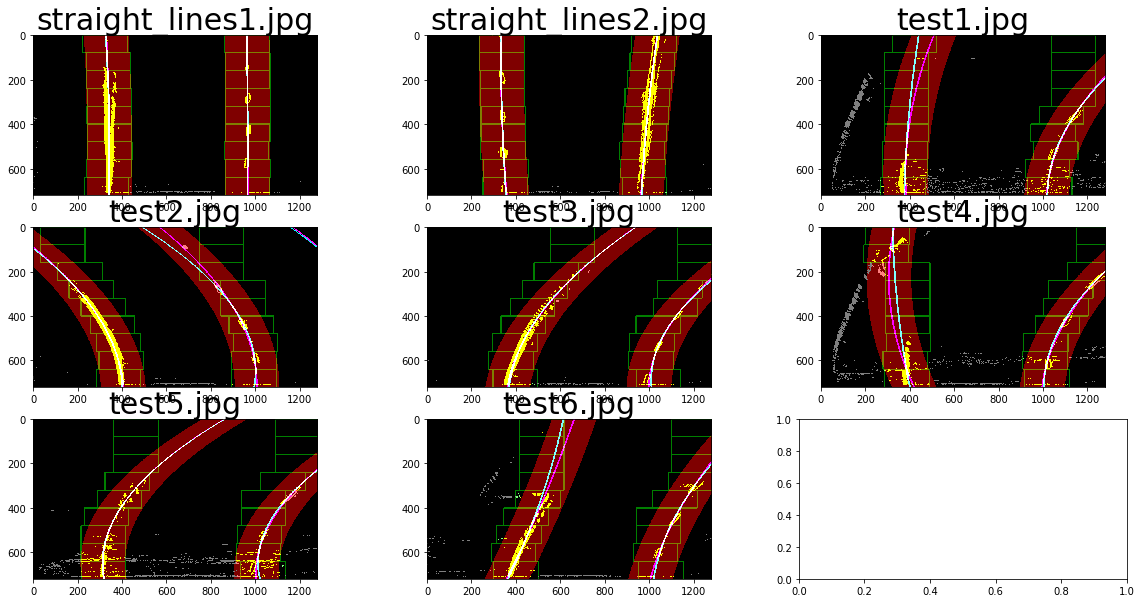

In [15]:
def combined_search(old_lane, image):
    slidewindow_lane, slidewindow_img = slidewindow_search(image)
    out_img = slidewindow_img
    next_lane = None
    if old_lane is not None:
        
        proximity_lane, proximity_img = proximity_search(old_lane, image)
        out_img = np.maximum(slidewindow_img, proximity_img)
        ys = np.linspace(0, image.shape[0]-1, image.shape[0] )
        average_lane = (old_lane + proximity_lane)/2
        proximity_lane_avg = (old_lane + proximity_lane)/2
        slidewindow_lane_avg = (old_lane + slidewindow_lane)/2
        proximity_insanity = proximity_lane_avg.insanity(ys)
        slidewindow_insanity = slidewindow_lane_avg.insanity(ys)
        if (proximity_insanity < slidewindow_insanity):
            next_lane = proximity_lane_avg
        else:
            next_lane = slidewindow_lane_avg
    else:
        next_lane = slidewindow_lane
    return next_lane, out_img

def combined_and_plot(image):
    # simple slide window search first to get estimate for polygon
    old_lane, _ = slidewindow_search(image)
    # then do proximity search on same image
    _, out_img = combined_search(old_lane, image)
    return out_img
    
run_all_test_images(combined_and_plot)


## Calculate Curvature, Offset from Center, and Decide About Fit

**Task:** Calculate the radius of curvature of the lane and the position of the vehicle with respect to center.

Here the idea is to take the measurements of where the lane lines are and estimate how much the road is curving and where the vehicle is located with respect to the center of the lane. The radius of curvature may be given in meters assuming the curve of the road follows a circle. For the position of the vehicle, you may assume the camera is mounted at the center of the car and the deviation of the midpoint of the lane from the center of the image is the offset you're looking for. As with the polynomial fitting, convert from pixels to meters.

### Calculate Lane Metrics

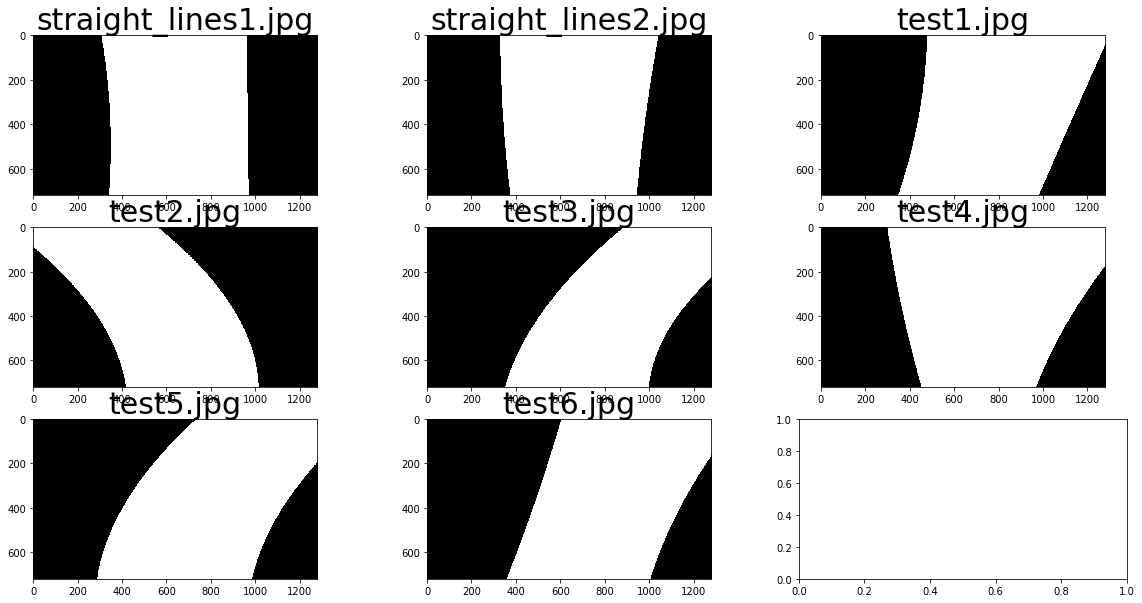

In [16]:
def plot_lane(image, lane, laneColor):
    fit_ys = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fit_xs = lane.left.sample_poly(fit_ys)
    right_fit_xs = lane.right.sample_poly(fit_ys)
    left_pts = np.array([np.transpose(np.vstack([left_fit_xs, fit_ys]))])
    right_pts = np.array([np.flipud(np.transpose(np.vstack([right_fit_xs, fit_ys])))])
    pts = np.hstack((right_pts, left_pts))
    cv2.fillPoly(image, np.int_(pts), laneColor)
    return image

def update_lane(old_lane, new_image, laneColor=(1., 1., 1.)):
    new_lane, out_img = combined_search(old_lane, new_image)
    lane_img = np.float_(np.zeros_like(new_image))
    plot_lane(lane_img, new_lane, laneColor)
    return new_lane, lane_img

def update_and_plot(image):
    first_lane, _ = slidewindow_search(image)
    _, image = update_lane(first_lane, image)
    return image
    
run_all_test_images(update_and_plot)

## Wrap Back to Original

**Task:** Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

The fit from the rectified image has been warped back onto the original image and plotted to identify the lane boundaries. This should demonstrate that the lane boundaries were correctly identified. An example image with lanes, curvature, and position from center should be included in the writeup (or saved to a folder) and submitted with the project.



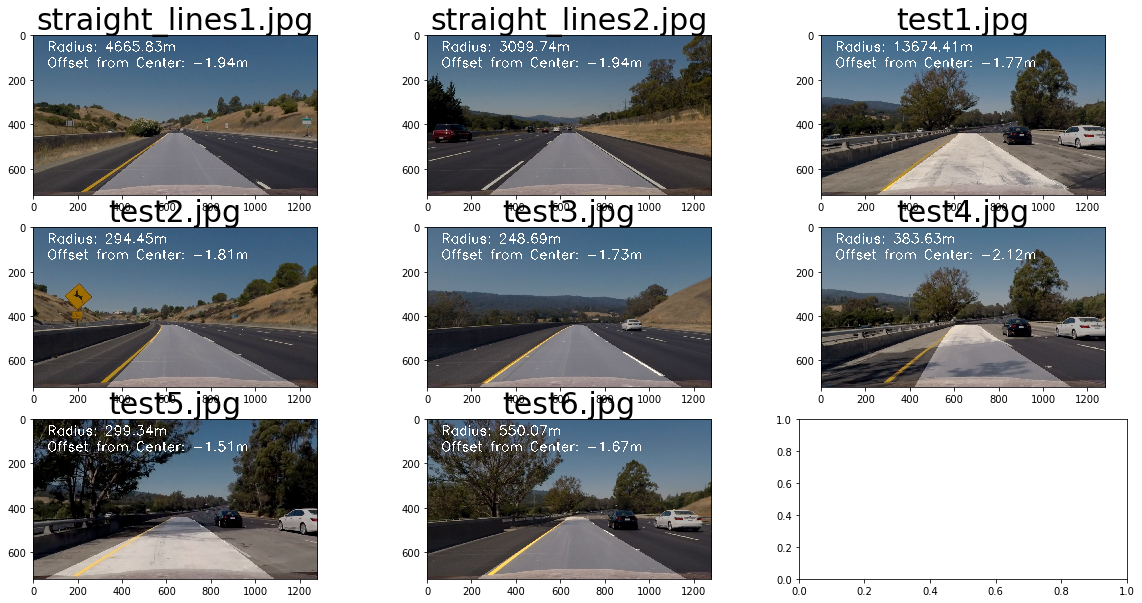

In [17]:
def plot_metrics(image, lane, textColor=(1., 1., 1.)):
    height = image.shape[0]
    width = image.shape[1]
    y = float(height)
    radius = lane.curvature(y)
    offset = lane.offset_from_center(y, image.shape[1]/2.)
    radius_text = "Radius: {:.2f}m".format(radius)
    offset_text = "Offset from Center: {:.2f}m".format(offset)
    radius_y = int(np.ceil(height*.1))
    offset_y = int(np.ceil(height*.2))
    x = int(np.ceil(width*.05))
    size = int(np.ceil(height*.002))
    strength = int(np.ceil(height*.004))
    cv2.putText(image, radius_text, (x, radius_y), cv2.FONT_HERSHEY_SIMPLEX, size, textColor, strength)
    cv2.putText(image, offset_text, (x, offset_y), cv2.FONT_HERSHEY_SIMPLEX, size, textColor, strength)
    return image

def update_warp(old_lane, new_image):
    global UNWARP_MATRIX
    dim = (new_image.shape[1], new_image.shape[0])
    out_image = undistort(new_image)
    lane, lane_image = update_lane(old_lane, out_image, laneColor=(1., 1., 1.))
    warp_lane_image = cv2.warpPerspective(lane_image, UNWARP_INV_MATRIX, dim, flags=cv2.INTER_LINEAR)
    out_image = cv2.addWeighted(out_image/255., 0.7, warp_lane_image, 0.3, 0)
    plot_metrics(out_image, lane, textColor=(1., 1., 1.))
    return lane, out_image

def update_warp_and_plot(image):
    first_lane, _ = slidewindow_search(image)
    _, image = update_warp(first_lane, image)
    return image

run_all_test_images(update_warp_and_plot)

## Process Video

**Task:** Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!)

The image processing pipeline that was established to find the lane lines in images successfully processes the video. The output here should be a new video where the lanes are identified in every frame, and outputs are generated regarding the radius of curvature of the lane and vehicle position within the lane. The pipeline should correctly map out curved lines and not fail when shadows or pavement color changes are present. The output video should be linked to in the writeup and/or saved and submitted with the project.

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

process_lane_buffer = None

def process_frame(image):
    global process_lane_buffer
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    process_lane_buffer, image = update_warp(process_lane_buffer, image)
    return np.int_(image*255)

def process_video(video_in, video_out):
    process_lane_buffer = None
    video_in_clip = VideoFileClip(video_in)
    video_out_clip = video_in_clip.fl_image(process_frame)
    video_out_clip.write_videofile(video_out, audio=False)

In [19]:
process_video("project_video.mp4", "project_video_output.mp4")

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [27:04<00:01,  1.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_video_output.mp4"))

## (Write-up, WIP, to be deleted)

**Task:** Provide a Writeup / README that includes all the rubric points and how you addressed each one. You can submit your writeup as markdown or pdf. Here is a template writeup for this project you can use as a guide and a starting point.

The writeup / README should include a statement and supporting figures / images that explain how each rubric item was addressed, and specifically where in the code each step was handled.

**Task:** For a standout submission, you should follow the suggestion in the lesson to not just search blindly for the lane lines in each frame of video, but rather, once you have a high-confidence detection, use that to inform the search for the position of the lines in subsequent frames of video. For example, if a polynomial fit was found to be robust in the previous frame, then rather than search the entire next frame for the lines, just a window around the previous detection could be searched. This will improve speed and provide a more robust method for rejecting outliers.

For an additional improvement you should implement outlier rejection and use a low-pass filter to smooth the lane detection over frames, meaning add each new detection to a weighted mean of the position of the lines to avoid jitter.

If you really want to go above and beyond, implement these methods on the challenge videos as well, or on your own videos you've recorded yourself.